In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from keras.models import Model,Sequential, load_model
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

In [15]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/kaggle/input/plant-village/PlantVillage'
train_dir = os.path.join(data_dir)
#test_dir = os.path.join(data_dir, 'test')

In [16]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,Pepper__bell___Bacterial_spot/0f72db9c-d635-44...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/1b8d3e98-43d9-44...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/b6d35d21-4812-4e...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/e4e7e5a2-5aa1-43...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/8b50f2db-cbf2-47...,0,Pepper__bell___Bacterial_spot


In [17]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato_healthy/7181181c-b571-4cf0-80c3-c52bd78...,14,Tomato_healthy
1,Potato___Early_blight/89d4dba2-3d9c-46fe-bac3-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/18f0fcbe-a99c-4d0d-a...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/621419a1-09f2-4a22-a569-6d81038...,14,Tomato_healthy
4,Tomato_Leaf_Mold/6ffea8bd-57cd-4fcf-b477-decec...,8,Tomato_Leaf_Mold


In [18]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
#Resizing image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [19]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

20639it [02:40, 128.68it/s]


Train Shape: (20639, 64, 64, 3)


In [20]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [21]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

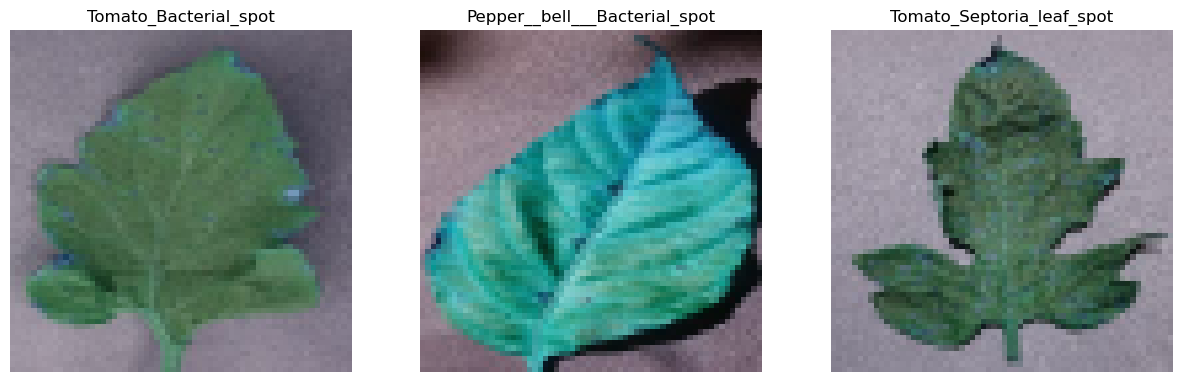

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [23]:
EPOCHS = 30
SIZE=64
N_ch=3

In [24]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [25]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
#generating batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
#fitting the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30

Epoch 1: val_loss improved from inf to 1.54783, saving model to model.h5
257/257 - 68s - loss: 2.4664 - accuracy: 0.3387 - val_loss: 1.5478 - val_accuracy: 0.5383 - lr: 0.0020 - 68s/epoch - 264ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.54783 to 0.68711, saving model to model.h5
257/257 - 35s - loss: 0.8900 - accuracy: 0.7176 - val_loss: 0.6871 - val_accuracy: 0.7866 - lr: 0.0020 - 35s/epoch - 137ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.68711 to 0.37771, saving model to model.h5
257/257 - 35s - loss: 0.5288 - accuracy: 0.8298 - val_loss: 0.3777 - val_accuracy: 0.8828 - lr: 0.0020 - 35s/epoch - 136ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.37771
257/257 - 33s - loss: 0.3797 - accuracy: 0.8774 - val_loss: 0.5050 - val_accuracy: 0.8418 - lr: 0.0020 - 33s/epoch - 129ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.37771
257/257 - 34s - loss: 0.3090 - accuracy: 0.9029 - val_loss: 0.6950 - val_accuracy: 0.7924 - lr: 0.0020 - 34

In [27]:
#model = load_model('/content/drive/MyDrive/KavyaBhojani-Infowarehouse/PlantVillageModel.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

129/129 [==============================] - 3s 21ms/step - loss: 0.1307 - accuracy: 0.9632
Final Loss: 0.13071678578853607, Final Accuracy: 0.963178277015686


1/1 [==============================] - 0s 39ms/step
[3.2273045e-10 1.2970959e-07 6.8537798e-04 1.5056075e-09 4.0425982e-07
 4.6375620e-13 4.6958260e-10 4.4157096e-12 7.1350437e-10 1.8534522e-09
 1.0338972e-11 6.4840126e-11 9.0177724e-13 2.5652719e-08 9.9931407e-01]


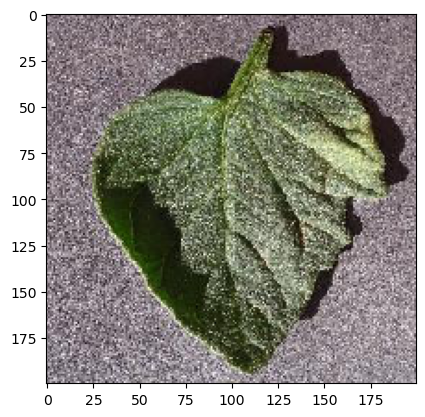

Prediction: Tomato_healthy


In [29]:
from skimage import io
import keras.utils as image

img = image.load_img('/kaggle/input/plantvillagetest/TomatoHealthy1.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/kaggle/input/plantvillagetest/TomatoHealthy1.JPG', grayscale=False, target_size=(200, 200))
disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])